In [1]:
import pandas as pd
import utils
import os
import ft_ensemble
import numpy as np
import ee

In [2]:
path_2_9km_models =   'pretrained_models/DenseSM_9km'

In [3]:
# path_2_pretrained_DenseSM-E
input_fine = pd.read_csv('/mnt/data2tb/Transfer-DenseSM-E_2/fusion/fusion_balanced_landsat.csv',index_col='s_index')
# Drop duplicate rows in 'sm_25' column
print(len(input_fine))
# Drop all rows where 'sm' values are greater than 0.7 
input_fine = input_fine[input_fine['sm'] <= 0.7]
input_fine = input_fine[input_fine['sm'] >= 0.1]
print(len(input_fine))

97727
97727


In [4]:
np.unique(input_fine['network'])

array(['CHINA_100m', 'CHINA_1km', 'INDIA_100m', 'INDIA_1km', 'VN'],
      dtype=object)

In [5]:
setup = {'lr':4e-4, # learning rate
        'epoch_Num':500,# number of epochs
        'swa_start':40,
        'alpha':0.7,# alpha in eq. 3
        'beta':'auto',# beta in eq. 3 and was determined by eq.4
        'domain_type':'coral',
        'mv_type':'MAPE',
        'ex':'ft12_models',
        'batchS':4096,# size of batch
        'br':1}# control the numbmer of unlabled samples and 9km samples, 1 means 1*batch_size
network_name=['CHINA_100m', 'CHINA_1km', 'INDIA_100m', 'INDIA_1km', 'VN', 'THAIBINH', 'GLOBAL']
base_dir = 'Demo' #%network_name
model_dir_e = os.path.join(base_dir,setup['ex'])
# if not os.path.exists(model_dir_e):
#     os.mkdir(model_dir_e)
os.makedirs(model_dir_e, exist_ok=True)

In [6]:
if isinstance(setup['beta'], str):
    print(setup['beta'])

auto


### Train SMAP data with specific ratio

Finetune sample: fusion_balanced_landsat repeat: 0
[-0.004  0.931  0.04   0.04   0.985]
Finetune sample: fusion_balanced_landsat repeat: 1
[-0.003  0.931  0.04   0.04   0.985]


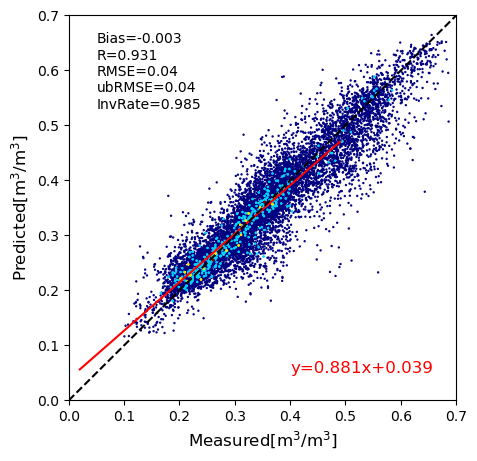

In [7]:
from sklearn.model_selection import train_test_split

nsample = 'fusion_balanced_landsat'
model_dir = os.path.join(model_dir_e, '%s'%nsample)
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

for r in range(2):
    if isinstance(setup['beta'], str):
        model_dir_r = os.path.join(model_dir, 'a%s_b%s_r%s'%(int(setup['alpha']*100), setup['beta'], str(r)))
    else:
        model_dir_r = os.path.join(model_dir,'a%s_b%s_r%s'%(int(setup['alpha']*100),int(setup['beta']*100),str(r)))
    if not os.path.exists(model_dir_r):
        os.mkdir(model_dir_r)
    s_index = input_fine.index.to_list()
    train_index, test_index = train_test_split(s_index, test_size=0.1, random_state=42, shuffle=True)
    train_val_index = [train_index, test_index]
    trainloader, val_data, targetloader, train_data = utils.prepare_train_val_data_highres(input_fine, train_val_index, setup['batchS'], setup['br'])
    modelX = ft_ensemble.Build_DenseSM(path_2_9km_models)
    modelX.rebuild_DenseSME()
    data = {'sl': trainloader,
            'tl':targetloader,
            'cl':None,
            'val_data': val_data,
            'train_data':train_data}
    
    print(f'Finetune sample: {nsample} repeat: {r}')
    ft = ft_ensemble.FinetuneModel(setup, data)
    ft.ft_ensemble(modelX, model_dir_r)
    df, res, m_specific_y=ft_ensemble.ensemble_results(model_dir_r, val_data)
    res.scatter_density_fig(os.path.join(model_dir_r,'ensemble.jpg'))
    print(res.stat_3d)